# overall workflow

## data acquisition
We scrape data from Tagesspiegel, a Berlin based newspaper covering local, national and international topics.

In [1]:
from datetime import date
from data_acquisition import scrape_tsp as st

In [9]:
today = str(date.today())
today

'2020-09-13'

In [3]:
st.get_links()

<Response [200]>


'wrote 159 links to data_acquisition/links-tsp-2020-09-13.txt'

In [4]:
scraped_file = 'data_acquisition/links-tsp-' + today + '.txt'
st.select_new_links(scraped_file)

got 159 links. 
wrote 85 links to data_acquisition/links-tsp-2020-09-13-new.txt


Before running the next cell, update the integer number in st.get_content( .. , int , ...)

Should be updated to the number that was returned the last time the cell ran.

In [5]:
import os

path_to_link_file='data_acquisition/links-tsp-'+today+'-new.txt'
path_to_output_folder='data_acquisition/tagesspiegel-'+today)

_, dirs, _ = next(os.walk('data_acquisition'))
#print(dirs)
if 'tagesspiegel-'+today in dirs:
    print("** folder exists **")
else:
    os.mkdir(path_to_output_folder, mode=0o744) 

#print(path_to_output_folder)
st.get_content(path_to_link_file,1573,path_to_output_folder)

1658

When articles are downloaded, add new links to 'bestand' (this file is needed to check for already downloaded articles, articles that are scraped on more than one occasion)

In [6]:
!cat $path_to_link_file >> 'data_acquisition/links-tsp-bestand.txt'

## data cleaning
 1. We check for advertisement in the articles' text. Ad text is included in brackets [...]
 2. We check for empty authors. 
 3. We check for missing date of publication
 4. We check for press releases
 5. remove content from plus.tagesspiegel.de (advertising, infotainment, Kundenbindung)
 
ad 2: An empty list of authors is replaced by the name of the paper: Tagesspiegel.

ad 4: An article that is a press release has closing characters (tsp) or (tsp,dpa) or similar. We remove the parenthesis and the enclosed text.

In [7]:
from data_cleaning import clean_tsp as ct

In [10]:
ct.clean_up('data_acquisition/tagesspiegel-'+today,today)

{'files inspected': 0,
 'files with ads': 35,
 'ads removed': 42,
 'files not clean': 7,
 'files not clean reasons': ['content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'too short',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'too short'],
 'dates imputed': 0}

To move clean articles to folder articles_02: Change the date to the value of today:

In [15]:
# move clean files to where they will be picked up downstream in our workflow
!mv data_acquisition/tagesspiegel-2020-09-13/*clean.json articles_02
# cannot concatenate string and variable in UNIX:
#!mv data_acquisition/tagesspiegel-${today}/*clean.json articles_02

In [18]:
ct.impute_description('articles_02')

### Basic testing 

for all files in folder that we'll use to read the articles from, when building the web app.
* files ending .json are in json format
* attribute text-link exists and is not empty
* json dict contains the required keys

In [1]:
import json
import os

_, _, file = next(os.walk('articles_02'))
#print(dirs)
#print(file)
compromised = []
required_attributes ={'title','text','image','description'}
for f in file:
    #print(f)
    if f.endswith('.json'):
        with open('articles_02/'+f,'r') as ff:
            a1 = ff.read()
        try: 
            a2 = json.loads(a1)
            try: 
                if a2['text-link'] in [None,'']:
                    compromised+=[{'file:':f,'violation':'text-link empty'}] 
                    continue
                if not required_attributes.issubset(set(a2.keys())):
                    compromised+=[{'file:':f,'violation':'missing keys '+str(required_attributes.difference(set(a2.keys())))}] 
                    continue
            except:
                compromised+=[{'file:':f,'exception':'missing key text-link'}]
                continue                               
        except: # json.loads 
            compromised+=[{'file:':f,'exception':'json.loads'}]
    else:
        compromised+=[{'file:':f,'exception':'.json'}]
        
print('compromised files, please remove them:')
compromised

compromised files, please remove them:


[{'file:': '.DS_Store', 'exception': '.json'}]

### protocols from previous cleanings

In [8]:
ct.clean_up('data_acquisition/tagesspiegel-2020-09-09','2020-09-09')

{'files inspected': 0,
 'files with ads': 63,
 'ads removed': 96,
 'files not clean': 8,
 'files bot clean reasons': ['too short',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)'],
 'dates imputed': 0}

In [5]:
ct.clean_up('tagesspiegel-2020-08-02','2020-08-02')

tagesspiegel-2020-08-02/00843.json
tagesspiegel-2020-08-02/00859.json
tagesspiegel-2020-08-02/00878.json
tagesspiegel-2020-08-02/00840.json


{'files inspected': 78,
 'files with ads': 43,
 'ads removed': 64,
 'files removed': 4,
 'files removed reasons': ['wrong type: author',
  'wrong type: imagegallery',
  'too short',
  'too short'],
 'dates imputed': 6}

In [3]:
ct.clean_up('tagesspiegel-2020-09-04','2020-09-04')

tagesspiegel-2020-09-04/01126.json
tagesspiegel-2020-09-04/01045.json
tagesspiegel-2020-09-04/01048.json


{'files inspected': 138,
 'files with ads': 61,
 'ads removed': 81,
 'files removed': 3,
 'files removed reasons': ['wrong type: imagegallery',
  'wrong type: imagegallery',
  'wrong type: imagegallery'],
 'dates imputed': 9}

In [4]:
ct.clean_up('tagesspiegel-2020-08-04','2020-08-04')

tagesspiegel-2020-08-04/00973.json
tagesspiegel-2020-08-04/01016.json
tagesspiegel-2020-08-04/00914.json


{'files inspected': 118,
 'files with ads': 60,
 'ads removed': 74,
 'files removed': 3,
 'files removed reasons': ['too short',
  'wrong type: imagegallery',
  'too short'],
 'dates imputed': 6}

In [8]:
ct.clean_up('tagesspiegel-2020-09-05','2020-09-05')

tagesspiegel-2020-09-05/01239.json


{'files inspected': 89,
 'files with ads': 40,
 'ads removed': 51,
 'files removed': 1,
 'files removed reasons': ['too short'],
 'dates imputed': 7}

## ml task

In [29]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [27]:
from ml_task import non_triv_ml as ml
# my code

ml.preprocess does some basic transfomation of a (German) text into a wordlist:

* Remove non ascii symbols and numbers / digits.
* Remove punctuation. 
* Lemmatize (for German language).
* remove stopp words (user defined stopp words, not downloaded from ... anywhere)
* remove words with 1 or 2 letters

In [28]:
# Stoppwords
my_stopper = ['bis','über','zum','oder','ja','an','so','ist','nur','sein','seine','deine','meine','am','sie','bei','durch','noch','sich','in','im','ihr','ihre','vor','zur','seit','es','zu','werden','haben','sein','von','jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich']

In [100]:
# examples
# print(ml.preprocess('Ich bin so wie du. Oder??', my_stopper))
# print(ml.preprocess('Das kann ja wohl nicht wahr sein. #$% ?? Alles nix, oder? 23! Ich gehe, esse, will schlafen.'))
# ml.preprocess('Das Haus am See. Da gehe ich hin, da bin ich gern.')

In [110]:
X = ml.read_articles_transform_to_df('articles_02/*clean.json',debug=False)

253 files to work with.


In [31]:
# check result of read articles:
X.head()

,file,file_name,title,text,description,image
0,articles_02/01417-clean.json,01417,Scheel rechnet mit baldiger Entscheidung über ...,Berlins Stadtentwicklungssenator Sebastian Sch...,Seit mehr als einem Jahr steht die Initiative ...,https://www.tagesspiegel.de/images/deutsche-wo...
1,articles_02/01420-clean.json,01420,Retourkutsche zum Zwinger,"Barocke Feste, da denkt man zuerst natürlich a...",Deutsches Versailles: Dresden feiert die Fürst...,https://www.tagesspiegel.de/images/heprodimage...
2,articles_02/01503-clean.json,01503,"Die Kunst, Geld zu verdienen","Berlin - Wenn Johann König einkaufen geht, hat...",Nirgendwo sonst leben so viele Künstler wie in...,https://www.tagesspiegel.de/images/no_text/622...
3,articles_02/01534-clean.json,01534,Wie gefährlich ist die Afrikanische Schweinepest?,"Die Gefahr rückt von Osten heran, und sie komm...","Politik, Behörden und Jäger haben einen Schlac...",https://www.tagesspiegel.de/images/heprodimage...
4,articles_02/01608-clean.json,01608,Die hässlich-mausgraue Revolution,"Der Porsche, der im morgendlichen Berufsverkeh...","Ein Auto, das kein Auto ist: Der Citroen Ami i...",https://www.tagesspiegel.de/images/ami/2618426...


### compare : cluster titles (short, fast) or cluster text (long, slow)

Is it better to cluster by applying K-means to to titles or to the full text of the article? Since titles are short, clustering them is faster. But is the quality of clustering the full texts higher?

How do the resulting clusters differ?

In [52]:
def my_clustering(list_of_strings, min_df , max_df , n_clusters):

    tfidf = TfidfVectorizer(max_df=max_df , min_df =min_df)
    km =  KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)

    my_pipe = Pipeline([('vect', tfidf), ('cluster', km) ])

    my_pipe.fit(list_of_strings)

    return(tfidf,km)

In [111]:
list_of_titles=[ml.preprocess(t, my_stopper) for t in X['title']]
list_of_titles[0]

'scheel rechnet baldig entscheidung berlin volksbegehren'

Silhouette Coefficient:  0.14895741274844296


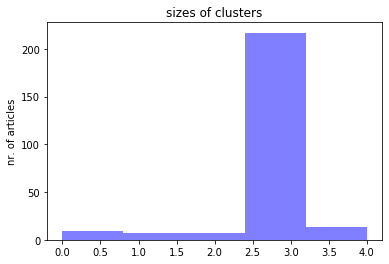

{'n': array([  9.,   7.,   7., 217.,  13.]),
 'frequencies': [0.036, 0.028, 0.028, 0.858, 0.051],
 'enthropy': 0.6030794752772756,
 'inertia': 172.7004903104006}

In [112]:
# clustering wrt titles
list_of = list_of_titles
tfidf_titles , km_titles=my_clustering(list_of, max_df=0.8 , min_df=2, n_clusters=5)
X['cluster']=pd.DataFrame(km_titles.labels_)
V = tfidf_titles.fit_transform(list_of)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_titles.labels_, sample_size=1000))
ml.evaluate_cluster(km_titles)
#cv.get_feature_names()[0:10]

In [ ]:
# it could be good to cluster on the basis of title / headline and description.
# there are more words and it is easier to find overlaps.

# another approach would be to use word embeddings, either pretrained.
# Or: train the word embeddings on the articles' text and then use it only for the titles.

results, 30 articles
* great positive silhouette coefficient: 0.7
* cluster sizes unevenly distributed, smallest cluster comprising around 5%

In [93]:
list_of_texts=[ml.preprocess(t, my_stopper) for t in X['text']]
list_of_texts[0][0:100]

'berlins stadtentwicklungssenator sebastian scheel link strebt senat september zulässigkeit geplant v'

Silhouette Coefficient:  0.025491227915546966


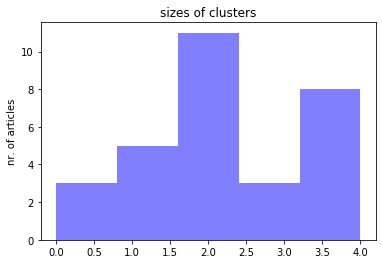

{'n': array([ 3.,  5., 11.,  3.,  8.]),
 'frequencies': [0.1, 0.167, 0.367, 0.1, 0.267],
 'enthropy': 1.479860840361009,
 'inertia': 21.445594755863244}

In [97]:
# clustering wrt full texts
list_of=list_of_texts
tfidf_texts, km_texts=my_clustering(list_of, max_df=0.7 , min_df=2, n_clusters=5)
X['cluster']=pd.DataFrame(km_texts.labels_)
V = tfidf_texts.fit_transform(list_of)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_texts.labels_, sample_size=1000))
ml.evaluate_cluster(km_texts)

### Result: Clustering wrt to titles or full text is not that different when looking at their statistics / scores.

The silouhette coefficient is around zero and inertia high in both cases. Relative differences are not high: Smaller inertia / higher inertia > 85% , difference in silhouette scores / range of scores < 10%

Enthropy is completely independent of our datas dimension, and about the same for both clustering methods: smaller enthropy / larger enthropy > 90%.

### Result: for the newsreader we prefer clustering wrt the full text

since cluster sizes are closer do a uniform distribtion (cluster sizer more evenly distributed).


## HPO: Hyper parameter optimization

In [113]:
from sklearn.model_selection import GridSearchCV

#parameters: min_df , max_df in vect , n_cluster in cluster

def my_hpo(list_of):
    param_grid = dict(vect__min_df=[1,2],
                vect__max_df=[0.8,0.9, 0.95],
                 cluster__n_clusters=[3,5,8])

    tfidf = TfidfVectorizer()
    km =  KMeans()
    pipe = Pipeline([('vect', tfidf), ('cluster', km) ])

    # Gridsearch arguments: cv=5 for 5-fold cross validation
    # verbose = 2: not so much output, verbose = 0: no messages during search
    grid_search=GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=0)
    grid_result=grid_search.fit(list_of)

    best_parameters = grid_search.best_estimator_.get_params()

    return({'min_df':best_parameters['vect'].min_df , 'max_df':best_parameters['vect'].max_df , 'n_clusters':best_parameters['cluster'].n_clusters})


### Best parameters obtained from HPO

In [ ]:
# to run the best clustering without looking at the best parameters from HPO
# pipe.set_params(**grid_search.best_estimator_.get_params())
# pipe.fit(list_of_texts)
# pipe.get_params()
# ml.evaluate_cluster(km)
# did not work

In [115]:
param_opt_titles= my_hpo(list_of_titles)
print(param_opt_titles)

{'min_df': 2, 'max_df': 0.9, 'n_clusters': 8}


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Silhouette Coefficient:  0.16887284699877883


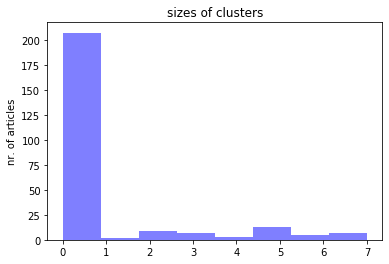

{'n': array([207.,   2.,   9.,   7.,   3.,  13.,   5.,   7.]),
 'frequencies': [0.818, 0.008, 0.036, 0.028, 0.012, 0.051, 0.02, 0.028],
 'enthropy': 0.8059473436949257,
 'inertia': 165.38648352354303}

In [116]:
list_of = list_of_titles
param_opt= param_opt_titles

# apply optimized parameters
tfidf_opt , km_opt=my_clustering(list_of, **param_opt)

# keep cluster assignment in X df
X['cluster']=pd.DataFrame(km_opt.labels_)

# output silhouette score and barchart
V = tfidf_opt.fit_transform(list_of)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_opt.labels_, sample_size=1000))
ml.evaluate_cluster(km_opt)

In [88]:
param_opt_texts= my_hpo(list_of_texts)
print(param_opt_texts)

{'min_df': 2, 'max_df': 0.95, 'n_clusters': 3}


Silhouette Coefficient:  0.024251846795386778


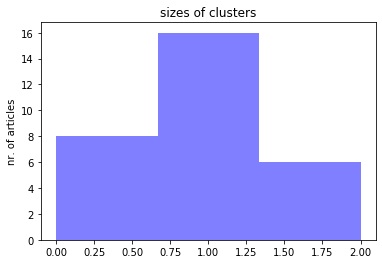

{'n': array([ 8., 16.,  6.]),
 'frequencies': [0.267, 0.533, 0.2],
 'enthropy': 1.009844494799268,
 'inertia': 22.96601618606468}

In [89]:
list_of = list_of_texts
param_opt= param_opt_texts

# apply optimized parameters
tfidf_opt , km_opt=my_clustering(list_of, **param_opt)

# keep cluster assignment in X df
X['cluster']=pd.DataFrame(km_opt.labels_)

# output silhouette score and barchart
V = tfidf_opt.fit_transform(list_of)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_opt.labels_, sample_size=1000))
ml.evaluate_cluster(km_opt)

### how stuff works, the small things ...

In [21]:
# how preprocessing works
ml.preprocess('Ich, meiner, mir, mich. Hallo hier ist ein Baum. %§/$. Oder 8 oder 9 oder 77 bzw. zwölf?? Läuft lief gelaufen')

WordList(['ich', 'meinern', 'mir', 'mich', 'hallo', 'hier', 'sein', 'ein', 'baum', 'oder', 'oder', 'oder', 'bzw', 'zwölf', 'laufen', 'laufen', 'laufen'])

In [23]:
# the list of titles
[' '.join(ml.preprocess(t)) for t in X['title'].head()]

['scheel rechnet mit baldig entscheidung über berlin volksbegehren',
 'retourkutschen zum zwinger',
 'die kunst geld zu verdienen',
 'wie gefährlich ist die afrikanisch schweinepest',
 'die hässlich mausgrau revolution']

## Word cloud representation for cluster

Collect all text from a specified cluster and create its wordcloud.

Some stopwords are features.

For each cluster save the articles belonging to the cluster in a csv file.

For each cluster create a wordcloud from all article titles to represent the cluster.


In [59]:
#!pip install wordcloud

from wordcloud import WordCloud


In [117]:
# word cloud from titles of clustered articles, does not matter if they were clustered wrt title or full text.
# But K has to be set accordingly.
# Also write csv files needed to present the articles in selected clusters (in html presentation)

clustered_by = 'titles'

if clustered_by == 'texts':
    K = param_opt_texts['n_clusters']
elif clustered_by == 'titles':
    K = param_opt_titles['n_clusters']
else:
    print('Set K as the number of clusters.')
    K=5
    
print('Cluster articles into ' + str(K) +' clusters')    
    
for k in range(K):
    Xcl = X.loc[X['cluster']==k]
    if clustered_by == 'titles':
        # join all titles in cluster, then preprocess the new string.
        feed_into_wc = ml.preprocess(' '.join(Xcl['title']), my_stopper)
    elif clustered_by == 'texts':
        feed_into_wc = ml.preprocess(' '.join(Xcl['text']), my_stopper) #this may become very / too large
    else:
        print('Now what?? How do you want to build the word cloud?')
        feed_into_wc = 'cluster '+str(k)
        
    if len(feed_into_wc)==0:
        feed_into_wc='empty'
        
    # write articles in this cluster to csv file
    ## needed later to display headlines and text from the (externally running) Flask server
    
    filename = 'html_pres/static/articles_cluster'+str(k)+'.csv'
    Y=Xcl.drop(columns=['text']) # text not needed anymore
    Y.to_csv(filename, sep=';', encoding='utf-8', header=True)
    
    wordcloud = WordCloud().generate(feed_into_wc)
    wordcloud.to_file('html_pres/static/image_cluster'+str(k)+'.png')

Cluster articles into 8 clusters


## presentation as html , website

* call an external python script to start the server (Flask)
* go to 127.0.0.0:5005 to interact with the website

In [ ]:
# clustered titles
#!python html_pres/app.py $param_opt_titles['n_clusters']
if clustered_by == 'texts':
    K=param_opt_texts['n_clusters']
elif clustered_by == 'titles':
    K=param_opt_titles['n_clusters']
else:
    K=2
    
!python html_pres/app.py $K

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
127.0.0.1 - - [14/Sep/2020 17:35:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2020 17:35:24] "GET /readmore/7 HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2020 17:35:53] "GET /readmore/7 HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2020 17:36:01] "GET /readmore/1 HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2020 17:37:42] "GET / HTTP/1.1" 200 -
